In [1]:
import cv2
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import torch
from pathlib import Path
import math

%matplotlib inline

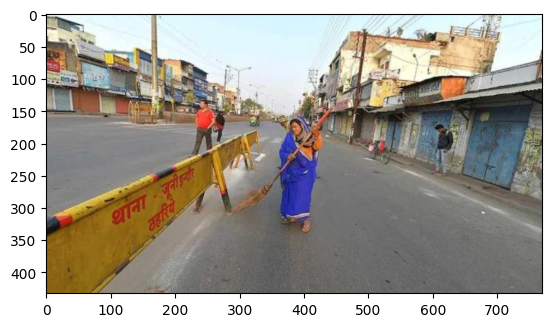

In [3]:
plt.imshow(cv2.imread('/content/Images/clean_27.jpg')[:, :, ::-1])

In [4]:
def show_images(path, title):
    h, w = 2, 4
    fig, ax = plt.subplots(h, w, figsize=(20, 10))

    for idx, file_name in enumerate(os.listdir(os.path.join(*path))):
        if idx == 8:
            break

        path.append(file_name)

        if Path(os.path.join(*path)).suffix == '.jpg':
            image = cv2.imread(os.path.join(*path))
            plt.subplot(h, w, idx+1)
            plt.title(title)
            plt.imshow(cv2.imread(os.path.join(*path))[:, :, ::-1])

        path.pop()

    plt.show()

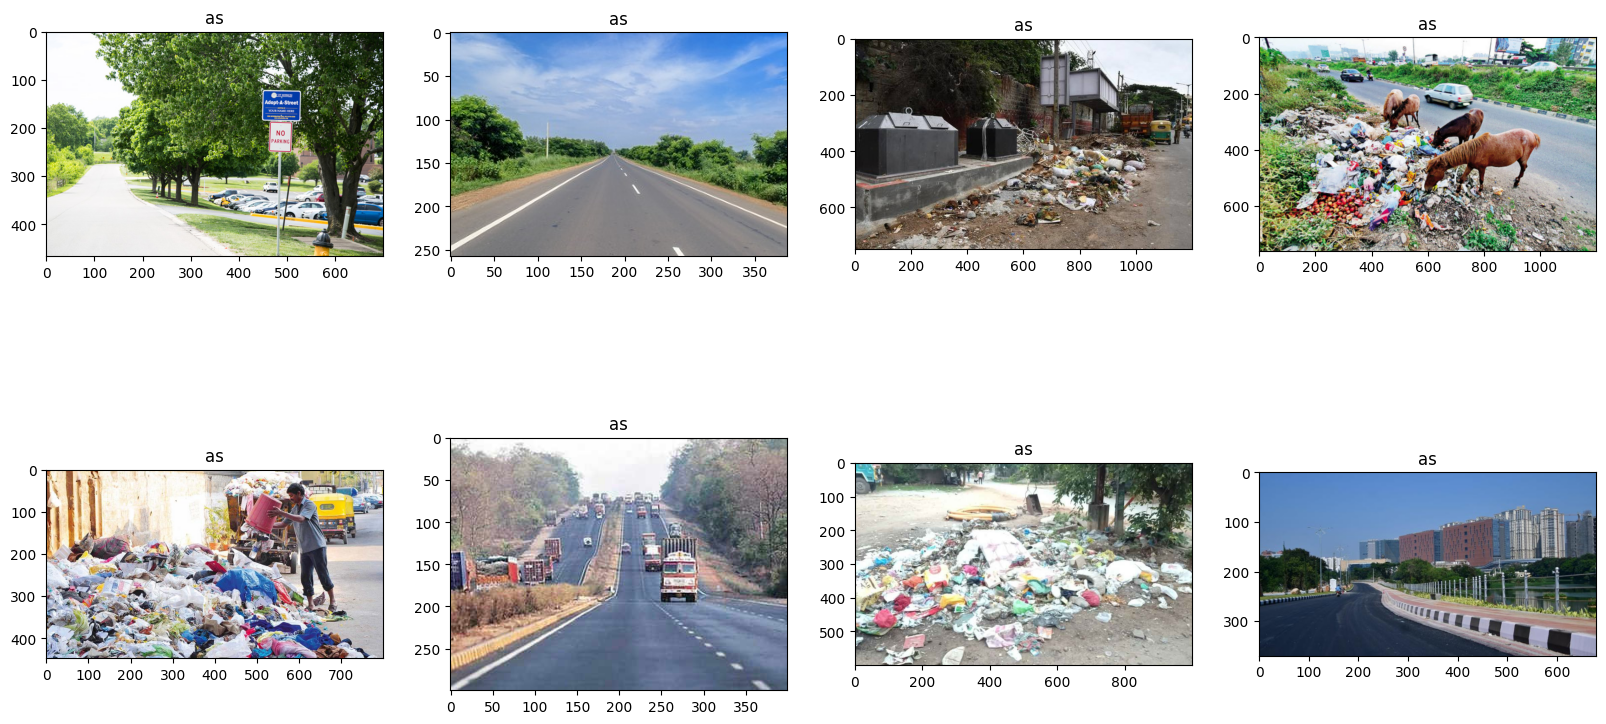

In [5]:
show_images(['/content/Images'], 'as')

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tr
from sklearn.preprocessing import minmax_scale

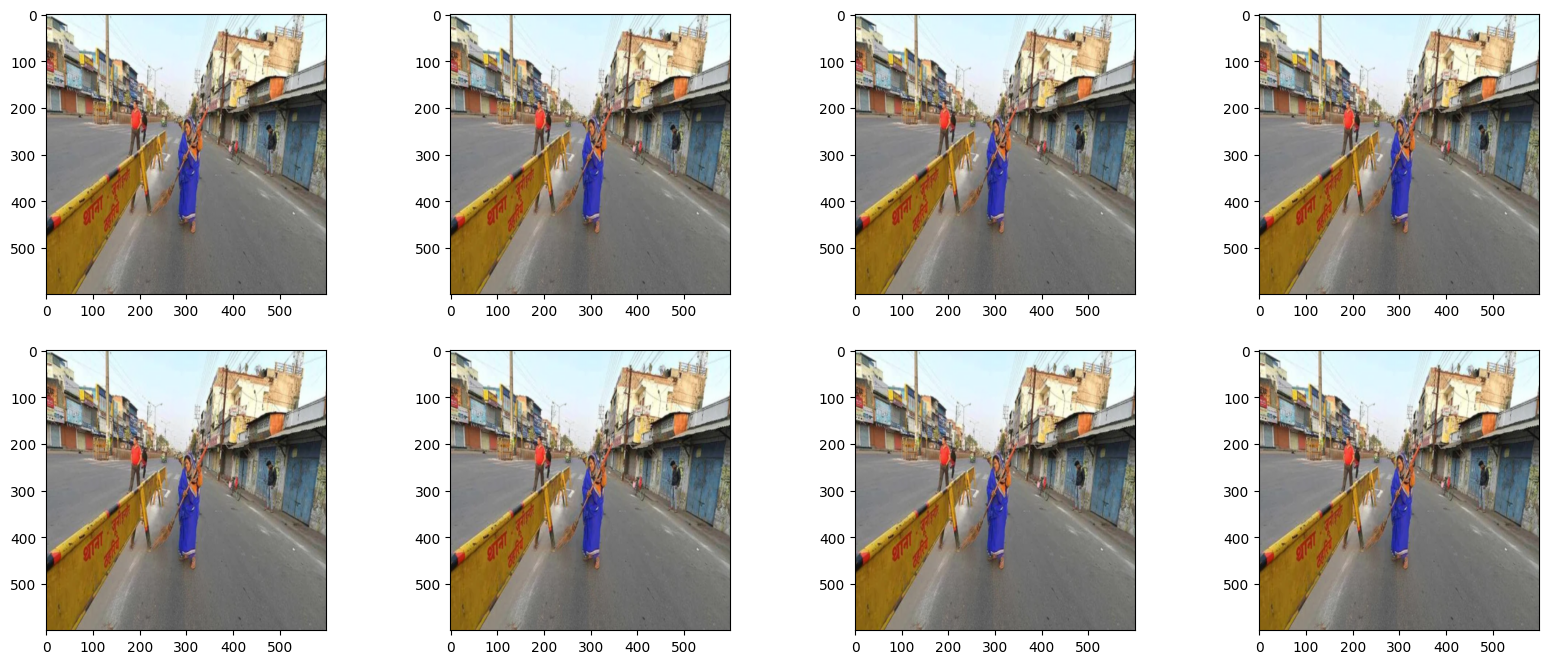

In [8]:
channel_mean = np.array([122.99410784, 122.99410784, 122.99410784])
channel_std = np.array([56.92372624, 56.92372624, 56.92372624])

image_prepare = tr.Compose([
    tr.ToPILImage(),
    tr.ToTensor(),
    tr.Resize((600, 600)),
    tr.Normalize(channel_mean / 255, channel_std / 255)
])

image = cv2.imread('/content/Images/clean_27.jpg')

def de_normalize(img):
    return minmax_scale(
        (img.reshape(3, -1) + channel_mean[:, None]) * channel_std[:, None],
        axis=1,
    ).reshape(*img.shape)


fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    transformed_image = image_prepare(image).numpy().transpose(1, 2, 0)[:, :, ::-1]
    plt.imshow(de_normalize(transformed_image))
plt.show()

In [9]:
import random

In [11]:
images_path = '/content/Images'

images_labels = []

for file_name in os.listdir(images_path):
    label = 0

    if file_name[:5] == 'clean':
        label = 1

    path = images_path + '/' + file_name

    image = cv2.imread(path)

    images_labels.append((image, label))

In [12]:
len(images_labels) * 0.8

n = 189

In [13]:
class ImageDataset(Dataset):
    """
        images_path ~ путь к папке с изображениями
    """
    def __init__(self, images):
        super(ImageDataset).__init__()

        self.images_labels = images

        random.shuffle(self.images_labels)


    def __getitem__(self, index):
        image, label = self.images_labels[index]

        image = image_prepare(image)

        return torch.Tensor(image), label

    def __len__(self):
        return len(self.images_labels)

In [14]:
train_data = ImageDataset(images_labels[:n])
test_data = ImageDataset(images_labels[n:])

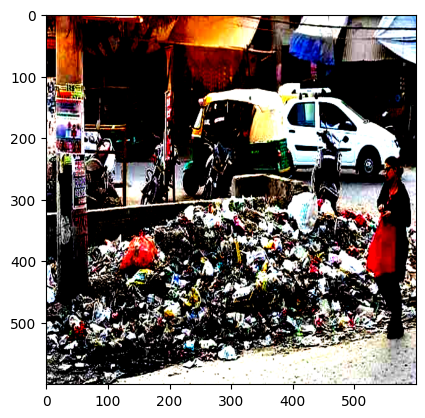

In [15]:
image, label = train_data[38]
plt.imshow(image.numpy().transpose(1, 2, 0)[:, :, ::-1])

In [16]:
label

0

In [17]:
batch_size = 12

dataloader_train = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
)

batch_size = 12

dataloader_test = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
)

In [18]:
from collections import OrderedDict
from torchvision.models import efficientnet_b7
from torch import nn

In [19]:
from collections import OrderedDict
from torchvision.models import efficientnet_b7
from torch import nn

class fc_block(nn.Module):
    def __init__(self, inputs, outputs):
        super(fc_block, self).__init__()

        self.fc = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(inputs, outputs)),
            ('bnorm1', nn.BatchNorm1d(outputs)),
            ('act1', nn.ReLU()),

            ('fc2', nn.Linear(outputs, outputs)),
            ('bnorm2', nn.BatchNorm1d(outputs)),
            ('ac2', nn.ReLU()),
        ]))

    def forward(self, x):
        return self.fc(x)


class img_fe_class(nn.Module):
    def __init__(self, dropout_p = 0.4):
        super(img_fe_class, self).__init__()

        eff_net = efficientnet_b7(pretrained=True)

        for param in eff_net.parameters():
            param.requires_grad = False

        inputs = eff_net.classifier[1].in_features

        eff_net.classifier = nn.Sequential(OrderedDict([
            ('fc_block1', fc_block(inputs, 256)),
            ('fc_block2', fc_block(256, 64)),
            ('fc_block3', fc_block(64, 16)),
            ('fc_out', nn.Linear(16, 2))
        ]))

        self.img_fe = eff_net

    def forward(self, imgs):
        return self.img_fe(imgs)

In [20]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

img_batch, label_batch = next(iter(dataloader_train))
img_batch = img_batch.to(device)
label_batch = label_batch.to(device)

model = img_fe_class().to(device)

res = model(img_batch)

assert res.shape[0] == np.sum(img_batch.shape[0])
assert res.shape[1] == 2

print(res.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 231MB/s]


torch.Size([12, 2])


In [21]:
import IPython
from math import ceil

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model = model.to(device)

def train_loop(model, dataloader, loss_fn, optimizer, step=0.05, history_loss=None, history_acc=None):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)

    size = len(dataloader.dataset)
    len_size = len(str(size))
    batches = ceil(size / dataloader.batch_size) - 1

    train_acc, train_loss = [], []
    percentage = 0

    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        #print(X.shape)

        # evaluate
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()

        # print info
        if batch / batches > percentage or batch == batches:
            out.update(f'[{int(percentage * size)}/{size}] Loss: {loss:>8f}')
            percentage += step

    if history_loss is not None:
        history_loss.append(np.mean(train_loss))
    if history_acc is not None:
        history_acc.append(np.mean(train_acc))

    return {'train_loss': np.mean(train_loss), 'train_acc': np.mean(train_acc)}

def test_loop(model, dataloader, loss_fn, history_loss=None, history_acc=None):

    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    batches = ceil(size / dataloader.batch_size)

    val_loss, val_acc = [], []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= batches
    correct /= size

    print(f"Validation accuracy: {(100*correct):>0.1f}%, Validation loss: {test_loss:>8f} \n")

    if history_loss is not None:
        history_loss.append(np.mean(val_loss))
    if history_acc is not None:
        history_acc.append(np.mean(val_acc))

    return {'val_loss': np.mean(val_loss), 'val_acc': np.mean(val_acc)}

In [22]:
loss_fn = torch.nn.functional.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 10

train_loss, train_acc = [], []
val_loss, val_acc = [], []

model = model.to(device)

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(model, dataloader_train, loss_fn, optimizer)
    test_loop(model, dataloader_test, loss_fn)

Epoch 1
-------------------------------


'[122/189] Loss: 0.585751'

Batch #:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Validation accuracy: 62.5%, Validation loss: 0.607249 

Epoch 2
-------------------------------


'[122/189] Loss: 0.496779'

Batch #:   0%|          | 0/15 [00:00<?, ?it/s]

Validation accuracy: 81.2%, Validation loss: 0.548546 

Epoch 3
-------------------------------


'[122/189] Loss: 0.499463'

Batch #:   0%|          | 0/15 [00:00<?, ?it/s]

Validation accuracy: 89.6%, Validation loss: 0.499618 

Epoch 4
-------------------------------


'[122/189] Loss: 0.469423'

Batch #:   0%|          | 0/15 [00:00<?, ?it/s]

Validation accuracy: 83.3%, Validation loss: 0.457041 

Epoch 5
-------------------------------


'[122/189] Loss: 0.377702'

Batch #:   0%|          | 0/15 [00:00<?, ?it/s]

Validation accuracy: 85.4%, Validation loss: 0.462225 

Epoch 6
-------------------------------


'[122/189] Loss: 0.410896'

Batch #:   0%|          | 0/15 [00:00<?, ?it/s]

Validation accuracy: 87.5%, Validation loss: 0.453201 

Epoch 7
-------------------------------


'[122/189] Loss: 0.361244'

Batch #:   0%|          | 0/15 [00:00<?, ?it/s]

Validation accuracy: 91.7%, Validation loss: 0.456676 

Epoch 8
-------------------------------


'[122/189] Loss: 0.345620'

Batch #:   0%|          | 0/15 [00:00<?, ?it/s]

Validation accuracy: 83.3%, Validation loss: 0.429381 

Epoch 9
-------------------------------


'[122/189] Loss: 0.326619'

Batch #:   0%|          | 0/15 [00:00<?, ?it/s]

Validation accuracy: 77.1%, Validation loss: 0.469643 

Epoch 10
-------------------------------


'[122/189] Loss: 0.333282'

Batch #:   0%|          | 0/15 [00:00<?, ?it/s]

Validation accuracy: 85.4%, Validation loss: 0.414308 

